# Final Project for Computational Tools in Data Science

## Preprocess the dataset

In [ ]:
import os
import json
import csv

### Listing out the json files in the dataset

In [ ]:
data_dir = os.path.join('..', 'spotify_million_playlist_dataset', 'data')
file_list = os.listdir(data_dir)

### Creating the csv file to write the data of the used playlists

In [ ]:
# (utf-8 encoding was important, as the dataset contained special characters)
csv_file = open('processed_dataset_separated.csv', 'w', newline='', encoding='utf-8')
writer = csv.writer(csv_file)

# criteria parameters on which playlists to use
min_followers = 5
min_tracks = 50
max_tracks = 100

# write the header of the csv file
fields = ['playlist_name', 'num_tracks', 'num_albums', 'num_followers', 'duration']
for i in range(max_tracks): fields.append(f'artist{i}')
for i in range(max_tracks): fields.append(f'track{i}')
for i in range(max_tracks): fields.append(f'album{i}')
writer.writerow(fields)

In [ ]:
# counter for the number of playlist which match our defined criteria
n = 0

# go through the 1000 json files
for filename in file_list:
    
    # load data from the current json file
    with open(os.path.join(data_dir, filename)) as json_file:
        data = json.load(json_file)
        
    # go through the 1000 playlists in the current json file
    for playlist in data['playlists']:
        
        # check if the playlist is withing our defined criteria
        if(playlist['num_followers'] >= min_followers and
                                    playlist['num_tracks'] >= min_tracks and
                                    playlist['num_tracks'] <= max_tracks):
            duration = 0
            artists = []
            tracks = []
            albums = []
            
            # collect the data from dictionaries to lists to easily write into our csv file
            for track in playlist['tracks']:
                artists.append(track['artist_name'])
                tracks.append(track['track_name'])
                albums.append(track['album_name'])
                duration += track['duration_ms'] / 1000
                
            # make all lists 100 elements long (the maximum number of tracks in a playlist we use) to match our csv file structure
            for i in range(len(artists), max_tracks):
                artists.append('')
                tracks.append('')
                albums.append('')
            
            # write the collected data into the csv file
            writer.writerow([playlist['name'], playlist['num_tracks'], playlist['num_albums'], playlist['num_followers'],
                             round(duration, 2)] + artists + tracks + albums)
            n += 1
            
# close the file
csv_file.close()

# print the number of playlist we will use in our analysis
print(n)

## Counting similarities

In [ ]:
import csv
import mmh3
import numpy as np

### Read our previously created dataset of 8850 playlists

In [ ]:
# open our created csv file (utf-8 encoding was important, as the dataset contained special characters)
csv_file = open('processed_dataset_separated.csv', newline='', encoding='utf-8')
reader = csv.reader(csv_file, delimiter=',')

# parameter for the maximum number of tracks in a single playlist
max_tracks = 100

# lists to store all elements of all 8850 playlists
playlist_names = []
artists = []
tracks = []
albums = []

# read all the data of our 8850 playlists from the csv file
for row in reader:
    
    # do not the the data from the header
    if row[0] == 'playlist_name': continue
    
    # store the title of the playlist in the current row
    playlist_names.append(row[0])
    
    # read all the 100 artist fields
    read_list = row[5:5+max_tracks]
    # remove empty fields from the list
    while '' in read_list: read_list.remove('')
    # add the data into our big artists matrix
    artists.append(read_list)
    
    read_list = row[5+max_tracks:5+2*max_tracks]
    while '' in read_list: read_list.remove('')
    tracks.append(read_list)
    
    read_list = row[5+2*max_tracks:5+3*max_tracks]
    while '' in read_list: read_list.remove('')
    albums.append(read_list)

# close the csv file as we loaded all the data into the RAM
csv_file.close()

In [ ]:
# create randomly ordered sets from our lists belonging to each playlist
artist_shingles = []
track_shingles = []
album_shingles = []
for i in range(len(playlist_names)):
    artist_shingles.append(set(artists[i]))
    track_shingles.append(set(tracks[i]))
    album_shingles.append(set(albums[i]))

### We used the same _listhash_, _minhash_ and _jaccard_ similarity functions we used to solve the exercise of week 4

In [ ]:
def listhash(l,seed):
    val = 0
    for e in l:
        val = val ^ mmh3.hash(e, seed)
    return val
def minhash(shingles: list, k: int):
    minhashes = []
    for i in range(k):
        minhashes.append(-1)
        for shingle in shingles:
            currenthash = listhash([shingle], i)
            if(currenthash < minhashes[i] or minhashes[i] == -1):
                minhashes[i] = currenthash
    return minhashes
def jaccard(list1: list, list2: list):
    crosssection = len(set(list1).intersection(list2))
    return crosssection / (len(list1) + len(list2) - crosssection)

### Calculate the minhashes of the playlists

In [ ]:
# parameter for the number of different seeds used for the hash function
# determined by trying multiple values from ~10 to ~100
k = 50

artist_hashes = []
track_hashes = []
album_hashes = []

# calculate the k number of different minhashes for each three shingle belonging to each 8850 playlist
for i in range(len(playlist_names)):
    artist_hashes.append(minhash(artist_shingles[i], k))
    track_hashes.append(minhash(track_shingles[i], k))
    album_hashes.append(minhash(album_shingles[i], k))

### Create the empty numpy arrays to later store our calculated similarity values
The diagonals always contain ones, as all playlists should exactly match when compared to themselves

In [ ]:
artist_similarity_matrix = np.empty((len(playlist_names), len(playlist_names)))
np.fill_diagonal(artist_similarity_matrix, 1)
track_similarity_matrix = np.empty((len(playlist_names), len(playlist_names)))
np.fill_diagonal(track_similarity_matrix, 1)
album_similarity_matrix = np.empty((len(playlist_names), len(playlist_names)))
np.fill_diagonal(album_similarity_matrix, 1)

### Calculate the similarity values based on the three lists based on all the possible pairs of the 8850 playlists

In [ ]:
for i in range(len(playlist_names)):
    for j in range(i+1, len(playlist_names)):
        
        # calculate the jaccard similarity of the minhash lists of the artists lists of the two playlists
        artist_similarity = jaccard(artist_hashes[i], artist_hashes[j])
        artist_similarity_matrix[i,j] = artist_similarity # put the value in the upper triangle of the artist similarity matrix
        artist_similarity_matrix[j,i] = artist_similarity # put the value in the lower triangle of the artist similarity matrix
        
        track_similarity = jaccard(track_hashes[i], track_hashes[j])
        track_similarity_matrix[i,j] = track_similarity
        track_similarity_matrix[j,i] = track_similarity
        
        album_similarity = jaccard(album_hashes[i], album_hashes[j])
        album_similarity_matrix[i,j] = album_similarity
        album_similarity_matrix[j,i] = album_similarity

### Collect all the values from the similarity matrices for creating the histograms

In [ ]:
artist_similarities = []
track_similarities = []
album_similarities = []
for i in range(len(playlist_names)):
    for j in range(i+1, len(playlist_names)):
        artist_similarities.append(artist_similarity_matrix[i,j])
        track_similarities.append(track_similarity_matrix[i,j])
        album_similarities.append(album_similarity_matrix[i,j])

### Plot the distirbution of all the calculated similarity values (artists, tracks and albums separately)

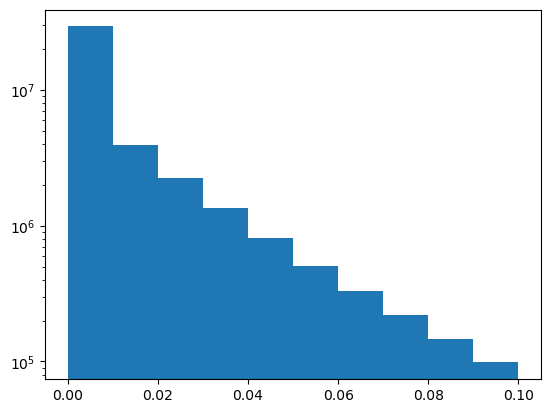

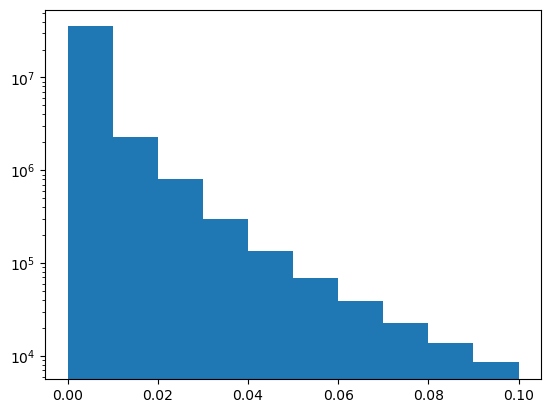

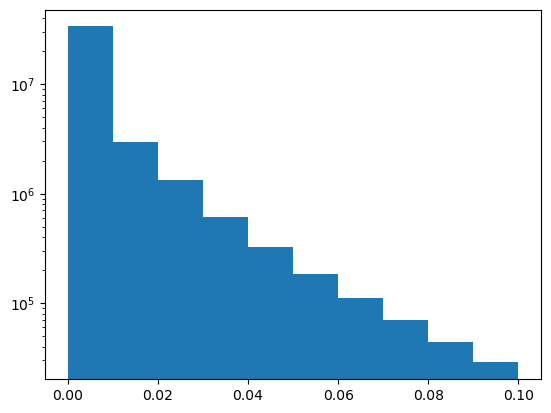

In [ ]:
import matplotlib.pyplot as plt
bins = np.arange(0,0.11,0.01)
plt.hist(artist_similarities, bins, log=True)
plt.show()
plt.hist(track_similarities, bins, log=True)
plt.show()
plt.hist(album_similarities, bins, log=True)
plt.show()

### Create csv files to store the final similarity matrices and write the header

In [ ]:
artist_similarity_csv_file = open('artist_similarity.csv', 'w', newline='', encoding='utf-8')
artist_similarity_writer = csv.writer(artist_similarity_csv_file)
track_similarity_csv_file = open('track_similarity.csv', 'w', newline='', encoding='utf-8')
track_similarity_writer = csv.writer(track_similarity_csv_file)
album_similarity_csv_file = open('album_similarity.csv', 'w', newline='', encoding='utf-8')
album_similarity_writer = csv.writer(album_similarity_csv_file)

first_row = [''] + playlist_names
artist_similarity_writer.writerow(first_row)
track_similarity_writer.writerow(first_row)
album_similarity_writer.writerow(first_row)

82486

### Write all the data into the created csv files
The header and the first column of the files contains the title of the related playlists

In [ ]:
for i in range(len(playlist_names)):
    
    artist_similarity_writer.writerow([playlist_names[i]] + list(artist_similarity_matrix[i]))
    track_similarity_writer.writerow([playlist_names[i]] + list(track_similarity_matrix[i]))
    album_similarity_writer.writerow([playlist_names[i]] + list(album_similarity_matrix[i]))
    
artist_similarity_csv_file.close()
track_similarity_csv_file.close()
album_similarity_csv_file.close()

## Clustering

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
df = pd.read_csv('processed_dataset_separated.csv')

In [ ]:
# create the lists of columns of each type to interpret data
playlist_columns = df.columns[df.columns.str.startswith('playlist_name')]
track_columns = df.columns[df.columns.str.startswith('track')]
album_columns = df.columns[df.columns.str.startswith('album')]
artist_columns = df.columns[df.columns.str.startswith('artist')]


### Conencting playlists by their shared tracks

In [ ]:
# creating a dictionary mapping tracks-to-playlists
track_playlists = {}
for index, row in df.iterrows():
    playlist_names = row[playlist_columns]
    tracks = row[track_columns]
    for playlist_name, track in zip(playlist_names, tracks):
        if pd.notnull(track):
            if track not in track_playlists:
                track_playlists[track] = set()
            track_playlists[track].add(playlist_name)

print(list(track_playlists.items())[:5])


[('Whatever You Like', {'Yeet'}), ('POWER', {'2020'}), ('Listen To The Music', {'motown'}), ('Ultralight Beam', {'Best Songs of 2016'}), ('I Would Be Sad', {'Autumnal '})]


In [ ]:
# creating a graph where playlists sharing the same songs are connected
G = nx.Graph()
for track, playlists in track_playlists.items():
    playlists_list = list(playlists)
    for i in range(len(playlists_list)):
        for j in range(i + 1, len(playlists_list)):
            G.add_edge(playlists_list[i], playlists_list[j])
print(G)

Graph with 2823 nodes and 6098 edges


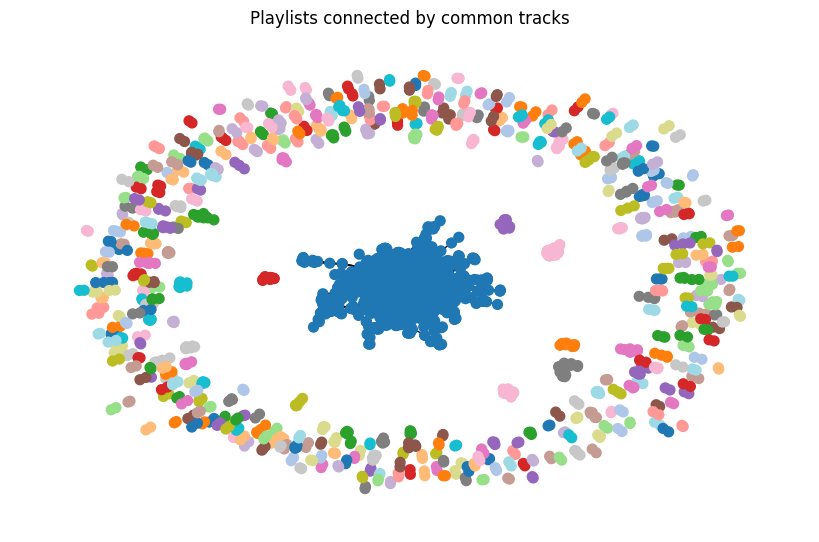

In [ ]:
pos = nx.spring_layout(G)
# using a color map with 20 different colors
color_map = {}
for i, component in enumerate(nx.connected_components(G)):
    for node in component:
        color_map[node] = plt.cm.tab20(i % 20) 


plt.figure(figsize=(8, 5))
nx.draw(G, pos=pos, node_color=[color_map[node] for node in G.nodes()], node_size=50, with_labels=False)
plt.title('Playlists connected by common tracks')
plt.show()

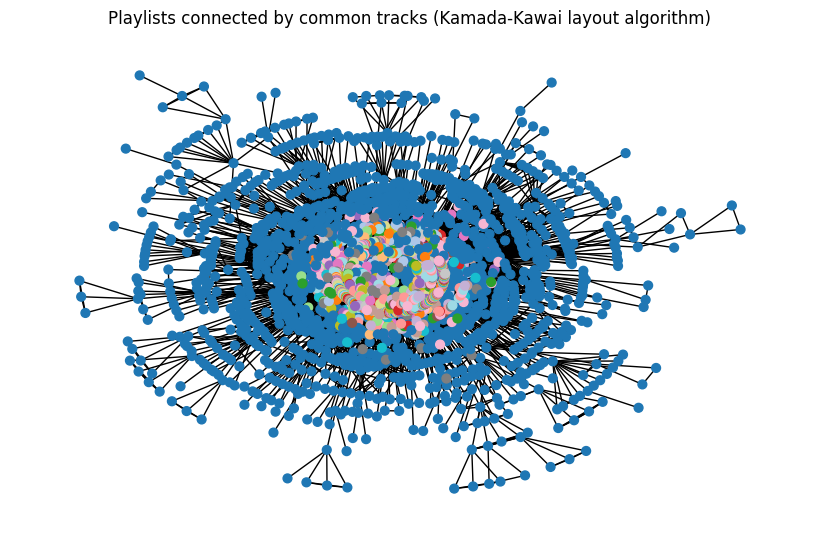

In [ ]:
# Kamada-Kawai layout algorithm
pos = nx.kamada_kawai_layout(G)  
color_map = {}
for i, component in enumerate(nx.connected_components(G)):
    for node in component:
        color_map[node] = plt.cm.tab20(i % 20)  

# trying to improve separation between clusters
plt.figure(figsize=(8, 5))
nx.draw(G, pos=pos, node_color=[color_map[node] for node in G.nodes()], node_size=40, with_labels=False)
plt.title('Playlists connected by common tracks (Kamada-Kawai layout algorithm)')
plt.show()

In [ ]:
clusters = list(nx.connected_components(G))
print(f'The total number of clusters of playlists connected by shared tracks: {len(clusters)}')

The total number of clusters of playlists connected by shared tracks: 454


### Conencting playlists by their shared albums

In [ ]:

# creating a dictionary mapping albums-to-playlists
album_playlists = {}
for index, row in df.iterrows():
    playlist_names = row[playlist_columns]
    albums = row[album_columns]
    for playlist_name, album in zip(playlist_names, albums):
        if pd.notnull(album):
            if album not in album_playlists:
                album_playlists[album] = set()
            album_playlists[album].add(playlist_name)
print(list(album_playlists.items())[:5])


[('Paper Trail', {'Yeet'}), ('My Beautiful Dark Twisted Fantasy', {'Right Now ', '2020', 'get lit'}), ('Toulouse Street', {'motown'}), ('The Life Of Pablo', {'jamss', 'FIRE 🔥', 'litness', 'fye', 'get ready!!!', 'Best Songs of 2016', 'play it', 'lit🔥🔥', 'sail', 'my favs'}), ('Emotionalism (Bonus Track Version)', {'Autumnal '})]


In [ ]:
# creating a graph where playlists sharing the same albums are connected
G_albums = nx.Graph()
for album, playlists in album_playlists.items():
    playlists_list = list(playlists)
    for i in range(len(playlists_list)):
        for j in range(i + 1, len(playlists_list)):
            G_albums.add_edge(playlists_list[i], playlists_list[j])
print(G_albums)

Graph with 3660 nodes and 13741 edges


In [ ]:
clusters_albums = list(nx.connected_components(G_albums))
print(f'The total number of clusters of playlists connected by shared albums: {len(clusters_albums)}')

The total number of clusters of playlists connected by shared albums: 396


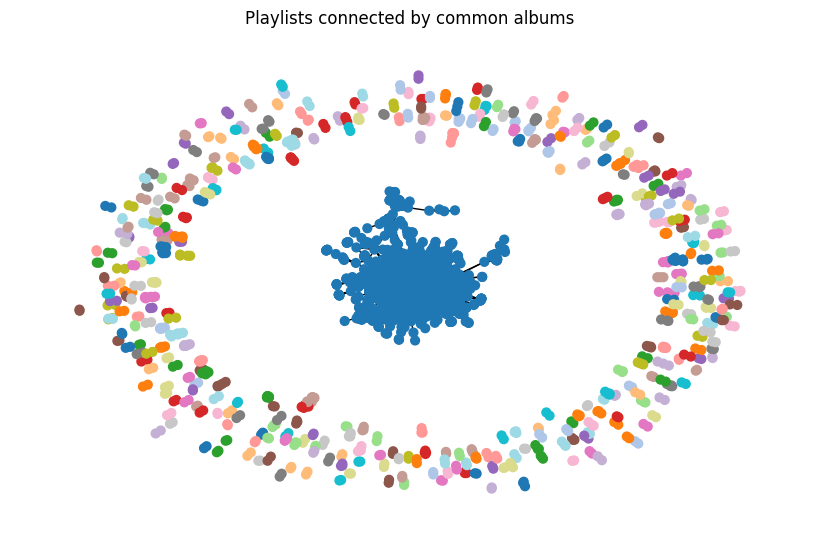

In [ ]:
pos = nx.spring_layout(G_albums)
color_map = {}
for i, component in enumerate(nx.connected_components(G_albums)):
    for node in component:
        color_map[node] = plt.cm.tab20(i % 20) 


plt.figure(figsize=(8, 5))
nx.draw(G_albums, pos=pos, node_color=[color_map[node] for node in G_albums.nodes()], node_size=40, with_labels=False)
plt.title('Playlists connected by common albums')
plt.show()

### Conencting playlists by their shared artists

In [ ]:

# creating a dictionary mapping artists-to-playlists
artist_playlists = {}
for index, row in df.iterrows():
    playlist_names = row[playlist_columns]
    artists = row[artist_columns]
    for playlist_name, artist in zip(playlist_names, artists):
        if pd.notnull(artist):
            if artist not in artist_playlists:
                artist_playlists[artist] = set()
            artist_playlists[artist].add(playlist_name)

print(list(artist_playlists.items())[:5])


[('T.I.', {'Yeet', 'Gym Mix'}), ('Kanye West', {'Right Now ', 'Lit', 'get lit', 'RACE DAY', 'anna', 'dope', 'lit🔥🔥', 'fye', 'LIT 🔥', '2020', 'Best Songs of 2016', 'Boner Jams', 'friday playlist', 'litness', 'get ready!!!', 'GET PUMPED!!!', 'Salad Days', 'sail', 'my favs', '/rAp', 'Straight fire', 'KANYE', 'Shuffle ', 'jamss', 'FIRE 🔥', 'play it', 'kanye west', 'My Mixtape', 'throwback bangers '}), ('The Doobie Brothers', {'motown'}), ('The Avett Brothers', {'mems', 'not rap', 'Autumnal '}), ('The Chainsmokers', {'Prom 2017', " Don't Let Me Down", 'Free', 'randoms', 'PARTAY', 'MIG', 'LOCO', 'Closer', 'SOS', 'Pump Up The Jam', 'halloween', 'fall favorites', 'Bumps', 'FitDance ', 'Relax Songs', 'SUMMER VIBES 2017', 'pregame', 'That New New', '2K16', 'volleyball ', 'turnip', 'Best of 2016', 'Jamzzz', 'Fire playlist ', 'Mix 2016', 'RR', 'Good vibes only:)', 'BEATS', 'Hype playlist'})]


In [ ]:
# creating a graph where playlists sharing the same artists are connected
G_artists = nx.Graph()
for artist, playlists in artist_playlists.items():
    playlists_list = list(playlists)
    for i in range(len(playlists_list)):
        for j in range(i + 1, len(playlists_list)):
            G_artists.add_edge(playlists_list[i], playlists_list[j], artist=artist)
print(G_artists)


Graph with 4471 nodes and 40746 edges


In [ ]:
clusters_artists = list(nx.connected_components(G_artists))
print(f'The total number of clusters of playlists connected by shared artists: {len(clusters_artists)}')

The total number of clusters of playlists connected by shared artists: 260


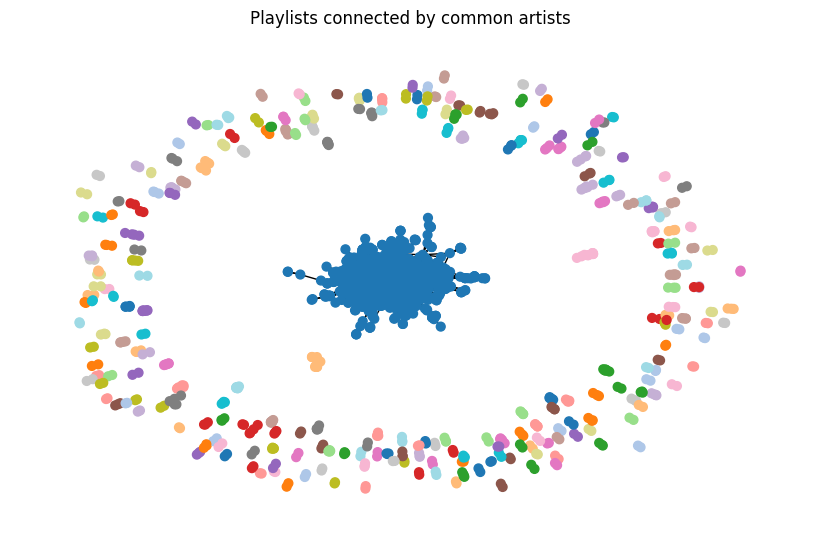

In [ ]:
pos = nx.spring_layout(G_artists)
color_map = {}
for i, component in enumerate(nx.connected_components(G_artists)):
    for node in component:
        color_map[node] = plt.cm.tab20(i % 20) 


plt.figure(figsize=(8, 5))
nx.draw(G_artists, pos=pos, node_color=[color_map[node] for node in G_artists.nodes()], node_size=40, with_labels=False)
plt.title('Playlists connected by common artists')
plt.show()

### Comparing the 3 graphs

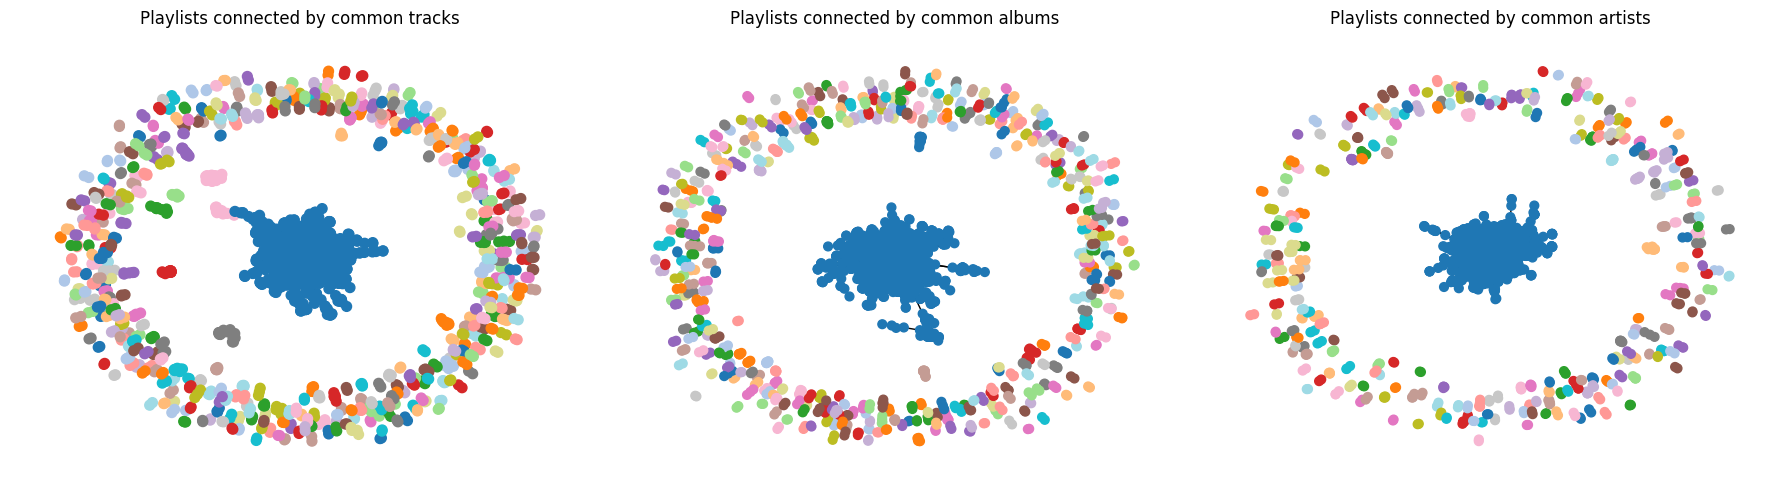

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  

# the plot for playlists connected by common tracks
pos_tracks = nx.spring_layout(G)
color_map_tracks = {}
for i, component in enumerate(nx.connected_components(G)):
    for node in component:
        color_map_tracks[node] = plt.cm.tab20(i % 20)
nx.draw(G, pos=pos_tracks, ax=axes[0], node_color=[color_map_tracks[node] for node in G.nodes()], node_size=50, with_labels=False)
axes[0].set_title('Playlists connected by common tracks')

# the plot for playlists connected by common albums
pos_albums = nx.spring_layout(G_albums)
color_map_albums = {}
for i, component in enumerate(nx.connected_components(G_albums)):
    for node in component:
        color_map_albums[node] = plt.cm.tab20(i % 20)
nx.draw(G_albums, pos=pos_albums, ax=axes[1], node_color=[color_map_albums[node] for node in G_albums.nodes()], node_size=40, with_labels=False)
axes[1].set_title('Playlists connected by common albums')

# the plot for playlists connected by common artists
pos_artists = nx.spring_layout(G_artists)
color_map_artists = {}
for i, component in enumerate(nx.connected_components(G_artists)):
    for node in component:
        color_map_artists[node] = plt.cm.tab20(i % 20)
nx.draw(G_artists, pos=pos_artists, ax=axes[2], node_color=[color_map_artists[node] for node in G_artists.nodes()], node_size=40, with_labels=False)
axes[2].set_title('Playlists connected by common artists')

plt.tight_layout()
plt.show()

In [ ]:
clusters1 = sorted(nx.connected_components(G), key=len, reverse=True)
clusters2 = sorted(nx.connected_components(G_albums), key=len, reverse=True)
clusters3 = sorted(nx.connected_components(G_artists), key=len, reverse=True)

largest_cluster_size1 = len(clusters1[0])
largest_cluster_size2 = len(clusters2[0])
largest_cluster_size3 = len(clusters3[0])

print("Size of the largest cluster for tracks:", largest_cluster_size1)
print("Size of the largest cluster for albums:", largest_cluster_size2)
print("Size of the largest cluster for artists:", largest_cluster_size3)

Size of the largest cluster for tracks: 1572
Size of the largest cluster for albums: 2643
Size of the largest cluster for artists: 3759


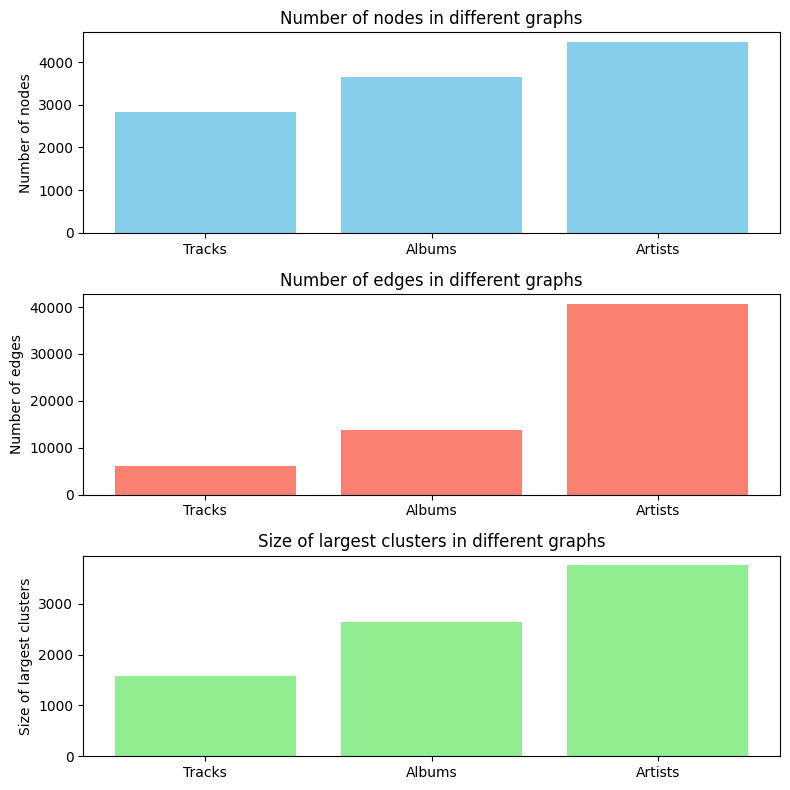

In [ ]:
nodes = [
    G.number_of_nodes(),
    G_albums.number_of_nodes(),
    G_artists.number_of_nodes()
]
edges = [
    G.number_of_edges(),
    G_albums.number_of_edges(),
    G_artists.number_of_edges()
]
largest_cluster_sizes = [
    largest_cluster_size1,
    largest_cluster_size2,
    largest_cluster_size3
]
graph_labels = ['Tracks', 'Albums', 'Artists']

# plotting bar charts for the numbers of nodes and edges of the 3 graphs
fig, axs = plt.subplots(3, figsize=(8, 8))

# the bar chart for numbers of nodes
axs[0].bar(graph_labels, nodes, color='skyblue')
axs[0].set_title('Number of nodes in different graphs')
axs[0].set_ylabel('Number of nodes')

# the bar chart for numbers of edges
axs[1].bar(graph_labels, edges, color='salmon')
axs[1].set_title('Number of edges in different graphs')
axs[1].set_ylabel('Number of edges')

# the bar chart for the sizes of the largest respective clusters
axs[2].bar(graph_labels, largest_cluster_sizes, color='lightgreen')
axs[2].set_title('Size of largest clusters in different graphs')
axs[2].set_ylabel('Size of largest clusters')

plt.tight_layout()
plt.show()

#### Investigating the largest cluster in the graph of playlists connected by artists

In [ ]:
clusters = sorted(nx.connected_components(G_artists), key=len, reverse=True)

# printing the clusters in decreasing order
# and their respective playlists
for i, cluster in enumerate(clusters[:5], start=1):
    print(f'Cluster {i} (Size: {len(cluster)}):')
    playlists_list = list(cluster)
    print(", ".join(playlists_list))
    print()

Cluster 1 (Size: 3759):
boys suck, Sing-A-Long, asdf, peachy , rap playlist, prom, Workout, Closer, HYFR, fall15., Break up songs, Elevate, Latina, Only, 🔥🔥🔥🔥🔥🔥, music, easy, Waves, hyphy, tgif, Reflection, PBR&B, chill 2, CranK, CHILL HIP-HOP, STRIP, Oldie, run, jammy, hippity hop ;), lit🔥, 🎧🎧, sad sad sad, Sexy Time, SKA, Best, 💦💦, country bangers , Thinking., misc, cali, Cool songs, RELAXX, white people music, Nick, sundays. , Christmas Tunes, 80s dance, awesome sauce, Baller, EDM Workout, bottoms up, tailgate, Indie Electronica, Slow Dancing in a Burning Room , mhmmm, JUNE 2017, Serenity, get lit, Bailoteo, lax, GOATS , Shower Songs, shower, All I need, for you, goodies, the fray, Tercer cielo, Old country, Classic R&B, ride, Classic Hits, Remixes, depressing, 1983, Electro, Sweater Weather, sleep playlist, Boner Jams, Jammies, QQ, Patience, Chill Vibez, INSPO, PROM!!, FRANCO DE VITA, South, chillstep,  rich homie quan, wedding jams , DONE, chilllll, beach , Summer playlist, Gradua

In [ ]:
# printing the clusters in decreasing order
# and their respective common artists
for i, cluster in enumerate(clusters[:5], start=1):
    print(f'Cluster {i} (Size: {len(cluster)}):')
    cluster_graph = G_artists.subgraph(cluster)
    common_artists = set()
    for edge in cluster_graph.edges(data=True):
        artist = edge[2].get('artist')
        if artist:
            common_artists.add(artist)
    print(f'Common Artists: {", ".join(common_artists)}')
    print()

Cluster 1 (Size: 3759):
Common Artists: Martin Jensen, Roy Woods, Saving Abel, Boston, Isaiah Rashad, A Great Big World, Milky Chance, Kim Walker-Smith, Relient K, Cage The Elephant, Wave Machines, YG, Conway Twitty, Chiddy Bang, Anthem Lights, Kehlani, alt-J, Snoop Dogg, Jónsi, Icona Pop, Kings Kaleidoscope, Young Money, The Temper Trap, Foster The People, 702, Govinda, Sloan, Dave Matthews Band, Franco De Vita, MS MR, *NSYNC, Tears For Fears, Calle 13, Bakermat, Third Eye Blind, Tory Lanez, Dario Marianelli, Michael Silverman, Dean Martin, Rihanna, Hillsong Worship, Daryl Hall & John Oates, Kenny Chesney, Sean Kingston, Sam Smith, Lil Jon, Alicia Keys, One Direction, Famous Dex, Glass Animals, Sugar Ray, Bebe Rexha, Aidonia, Major Lazer, Cherub, Bruce Springsteen, Bing Crosby, Mike Posner, Birdy, Barry Manilow, Kendrick Lamar, Boys Like Girls, Hardwell, Nicki Minaj, Omarion, J Balvin, Papa Roach, Alexis y Fido, PnB Rock, Pharrell Williams, Miike Snow, Kacy Hill, Aer, Rudimental, La O

In [ ]:
clusters = sorted(nx.connected_components(G_artists), key=len, reverse=True)

# getting the largest cluster
biggest_cluster = max(clusters, key=len)
num_rows = len(biggest_cluster)

filtered_df = df[df['playlist_name'].isin(biggest_cluster)].copy()

# removing duplicate rows based on the playlist_name column
filtered_df.drop_duplicates(subset='playlist_name', keep='first', inplace=True)

print(filtered_df['playlist_name'].unique())
print(f"size: {len(filtered_df['playlist_name'].unique())}")

# save the playlists in the largest cluster to a new csv file
filtered_df.to_csv('biggest_cluster.csv', index=False)

['Yeet' '2020' 'motown' ... 'Cafe' 'neon trees' 'Squad']
size: 3759


In [ ]:
df = pd.read_csv('biggest_cluster.csv')
playlist_names = df['playlist_name']

# saving an simpler csv file with only the 'playlist_name' column
playlist_names.to_csv('biggest_cluster_simple.csv', index=False)

In [ ]:
biggest_cluster_graph = G_artists.subgraph(biggest_cluster)

# counting appearances of each artist in the largest cluster
artist_counter = Counter()
for edge in biggest_cluster_graph.edges(data=True):
    artist = edge[2].get('artist')
    if artist:
        artist_counter[artist] += 1

# printing the artists in decreasing order of appearance
sorted_artists = sorted(artist_counter.items(), key=lambda x: x[1], reverse=True)
for artist, count in sorted_artists[:35]:
    print(f'{artist}: {count} times')

Drake: 8456 times
The Weeknd: 1169 times
Kanye West: 1140 times
J. Cole: 1071 times
Kendrick Lamar: 1012 times
Beyoncé: 776 times
Lil Uzi Vert: 775 times
Rihanna: 771 times
The Chainsmokers: 731 times
Ed Sheeran: 699 times
Justin Bieber: 648 times
Coldplay: 628 times
Calvin Harris: 494 times
Chance The Rapper: 493 times
Future: 490 times
Post Malone: 434 times
Childish Gambino: 375 times
Maroon 5: 374 times
Kygo: 344 times
JAY Z: 325 times
Chris Brown: 324 times
Mariah Carey: 320 times
Travis Scott: 298 times
Flume: 275 times
John Mayer: 275 times
Big Sean: 272 times
blackbear: 253 times
Khalid: 253 times
Major Lazer: 251 times
Rae Sremmurd: 251 times
Lil Wayne: 244 times
Hillsong United: 242 times
G-Eazy: 231 times
Lana Del Rey: 231 times
Migos: 209 times


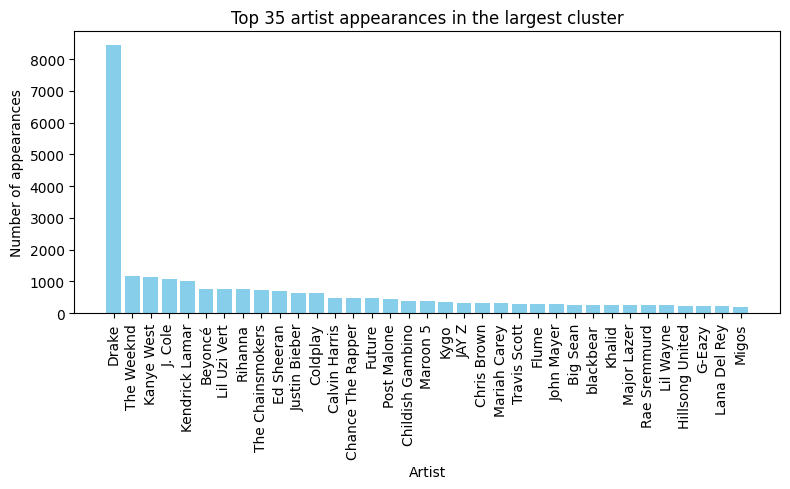

In [ ]:
# taking only the top 35 artists for easier plotting
top_artists, top_counts = zip(*sorted_artists[:35])

# plotting the appearances of most popular artists in the largest cluster
plt.figure(figsize=(8, 5))
plt.bar(top_artists, top_counts, color='skyblue')
plt.xlabel('Artist')
plt.ylabel('Number of appearances')
plt.title('Top 35 artist appearances in the largest cluster')
plt.xticks(rotation=90) 
plt.tight_layout()  
plt.show()

## Wordcloud

### Adding the genres from other dataset

In [ ]:
import os
import json
import csv
from numpy import genfromtxt
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
import math

In [ ]:
# Dataset containing playlist and artist information
spotify_dataset = pd.read_csv("processed_dataset_separated.csv")
# Dataset containing genres and additional information
genre_dataset = pd.read_csv("data_w_genres.csv")
genres = np.asarray(genre_dataset)

In [ ]:
# Getting a list of all artists in a playlist. This is done for each playlist
artist_dataset = np.asarray(spotify_dataset)[:,5:380]
artists = []
for artist_list in artist_dataset:
    temp = []
    for artist in artist_list:
        if pd.notna(artist):
            temp.append(artist)
    artists.append(temp)
    #artists.append({x for x in a if pd.notna(x)})

In [ ]:
# Create dataset of playlists and their artists in a way that makes it possible 
# to merge with genre dataset based on key (artist)
csv_file = open('genres_and_artists.csv', 'w', newline='', encoding='utf-8')
writer = csv.writer(csv_file)
n = 0
writer.writerow(['playlist_name', 'num_followers', 'num_tracks', 'artists'])
for x in range(len(artists)):
    for artist in artists[n]:
        writer.writerow([spotify_dataset.playlist_name[n], spotify_dataset.num_followers[n], spotify_dataset.num_tracks[n], artist])
    n += 1
csv_file.close()

In [ ]:
# Open newly create dataset of playlists and their artists
genres_and_artists = pd.read_csv("genres_and_artists.csv")

In [ ]:
# Merge datasets to add artist information to spotify playlist
final_data=genres_and_artists.merge(genre_dataset,on="artists")
final_data.to_csv("processed_genre_dataset.csv")

### Generating histograms and wordclouds

In [ ]:
import os
import json
import csv
from numpy import genfromtxt
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
import math

In [ ]:
# CSV dataset for playlists and artists - converted into an array
final_data = pd.read_csv("processed_genre_dataset.csv")
final_data = np.asarray(final_data)
# CSV dataset for the largest cluster
cluster_data = pd.read_csv("biggest_cluster_simple.csv")

In [ ]:
# Creates a list of all artists in a playlist
final_playlists = []
known_playlists = [final_data[0][1]]
temp = []
for data in final_data:
    if data[1] not in known_playlists:
        known_playlists.append(data[1])
        final_playlists.append(temp)
        temp = []
    temp.append(data)

In [ ]:
def Convert(string):
    """Convert a string into a list.
    Also removes the characters '[' , ']'
    """
    string = string.replace('[', '').replace(']', '').replace("'", '')
    li = list(string.split(", "))
    return li

In [ ]:
# Creates json containing all values descriping an artist, such as genre, acoustics, etc...
complete_playlist = {}
for playlist in final_playlists:
    artists = []
    genres = []
    acoustics = []
    dancability = []
    duration = []
    energy = []
    instrumentalness = []
    liveliness = []
    loudness = []
    speechiness = []
    tempo = []
    valence = []
    popularity = []
    artist = []
    
    for song in playlist:
        artists += Convert(song[4])
        genres += Convert(song[5])
        acoustics.append(song[6])
        dancability.append(song[7])
        duration.append(song[8])
        energy.append(song[9])
        instrumentalness.append(song[10])
        liveliness.append(song[11])
        loudness.append(song[12])
        speechiness.append(song[13])
        tempo.append(song[14])
        valence.append(song[15])
        popularity.append(song[15])
        
    complete_playlist[song[1]] = {}
    complete_playlist[song[1]]['artists'] = artists
    complete_playlist[song[1]]['genres'] = genres
    complete_playlist[song[1]]['acoustics'] = acoustics
    complete_playlist[song[1]]['dancability'] = dancability
    complete_playlist[song[1]]['duration'] = duration
    complete_playlist[song[1]]['energy'] = energy
    complete_playlist[song[1]]['instrumentalness'] = instrumentalness
    complete_playlist[song[1]]['liveliness'] = liveliness
    complete_playlist[song[1]]['loudness'] = loudness
    complete_playlist[song[1]]['speechiness'] = speechiness
    complete_playlist[song[1]]['tempo'] = tempo
    complete_playlist[song[1]]['valence'] = valence
    complete_playlist[song[1]]['popularity'] = popularity

In [ ]:
# Creates json of data in the largest cluster
biggest_cluster = {}

for key in list(complete_playlist["That's What I Like"].keys()):
    errors = 0
    temp = []
    for playlist in list(cluster_data.playlist_name):
        try:
            temp += complete_playlist[playlist][key]
        except:
            errors += 1
    biggest_cluster[key] = temp
print(errors)

2752


In [ ]:
# Creates json of the top 5 most followed playlists
most_popular_list = ["That's What I Like", "Jack's Playlist", 'FARRUKO', 'FEELS', 'Workout Playlist']

most_popular = {}
for key in list(complete_playlist["That's What I Like"].keys()):
    temp = []
    for playlist in most_popular_list:
        temp += complete_playlist[playlist][key]
    most_popular[key] = temp

In [ ]:
# Since largest cluster contains unfiltered data, these are 
# different measures on how much data there is after filtering
print('size of cluster = ', len(cluster_data.playlist_name))
print('number of non overlap between cluster and filtered playlists = ', errors)
print('this is the cluster size assuming filters = ', len(cluster_data.playlist_name) - errors)
print('number of playlists assuming filters = ', len(complete_playlist))

size of cluster =  3759
number of non overlap between cluster and filtered playlists =  2752
this is the cluster size assuming filters =  1007
number of playlists assuming filters =  5156


In [ ]:
def plotHist(x_num,y_num,keys_list):
    """Plots histograms of height x_num and width y_num.
    Data shown is determined by keys_list containing a list of 
    keys in the json of playlist data.
    
    Shows 3 histograms per key: 
    - 1 of ALL songs in dataset 
    - 1 of the largest cluster
    - 1 of the top 5 most followed playlists
    """
    figure, axis = plt.subplots(x_num, y_num)
    plt.figure(figsize=(10,20))
    figure.tight_layout(pad=4.0)
    x = 0
    y = 0
    font_size = 7
    for targets in keys_list:
        all_targets = []
        for playlist_name in complete_playlist:
            all_targets += complete_playlist[playlist_name][targets] 

        axis[math.floor(x*2/x_num), y%y_num].hist(all_targets, edgecolor="red", bins=10)
        axis[math.floor(x*2/x_num), y%y_num].set_title(targets + ' score all playlists',
          fontsize = font_size)
        if targets == 'duration':
            axis[math.floor(x*2/x_num), y%y_num].set_xlabel(targets + ' [ms]',
          fontsize = font_size)
        elif targets == 'tempo':
            axis[math.floor(x*2/x_num), y%y_num].set_xlabel(targets + ' [BPM]',
          fontsize = font_size)
        elif targets == 'loudness':
            axis[math.floor(x*2/x_num), y%y_num].set_xlabel(targets + ' [DB]',
          fontsize = font_size)
        else:
            axis[math.floor(x*2/x_num), y%y_num].set_xlabel(targets,
          fontsize = font_size)
        axis[math.floor(x*2/x_num), y%y_num].set_ylabel('count #')

        y += 1

        axis[math.floor(x*2/x_num), y%y_num].hist(biggest_cluster[targets], edgecolor="red", bins=10)
        axis[math.floor(x*2/x_num), y%y_num].set_title(targets + ' score in biggest cluster',
          fontsize = font_size)
        if targets == 'duration':
            axis[math.floor(x*2/x_num), y%y_num].set_xlabel(targets + ' [ms]',
          fontsize = font_size)
        elif targets == 'tempo':
            axis[math.floor(x*2/x_num), y%y_num].set_xlabel(targets + ' [BPM]',
          fontsize = font_size)
        elif targets == 'loudness':
            axis[math.floor(x*2/x_num), y%y_num].set_xlabel(targets + ' [DB]',
          fontsize = font_size)
        else:
            axis[math.floor(x*2/x_num), y%y_num].set_xlabel(targets,
          fontsize = font_size)
        axis[math.floor(x*2/x_num), y%y_num].set_ylabel('count #')

        y += 1
        
        axis[math.floor(x*2/x_num), y%y_num].hist(most_popular[targets], edgecolor="red", bins=10)
        axis[math.floor(x*2/x_num), y%y_num].set_title(targets + ' score in most popular playlists',
          fontsize = font_size)
        if targets == 'duration':
            axis[math.floor(x*2/x_num), y%y_num].set_xlabel(targets + ' [ms]',
          fontsize = font_size)
        elif targets == 'tempo':
            axis[math.floor(x*2/x_num), y%y_num].set_xlabel(targets + ' [BPM]',
          fontsize = font_size)
        elif targets == 'loudness':
            axis[math.floor(x*2/x_num), y%y_num].set_xlabel(targets + ' [DB]',
          fontsize = font_size)
        else:
            axis[math.floor(x*2/x_num), y%y_num].set_xlabel(targets,
          fontsize = font_size)
        axis[math.floor(x*2/x_num), y%y_num].set_ylabel('count #')

        y += 1
        x += 1
        
    plt.show() 

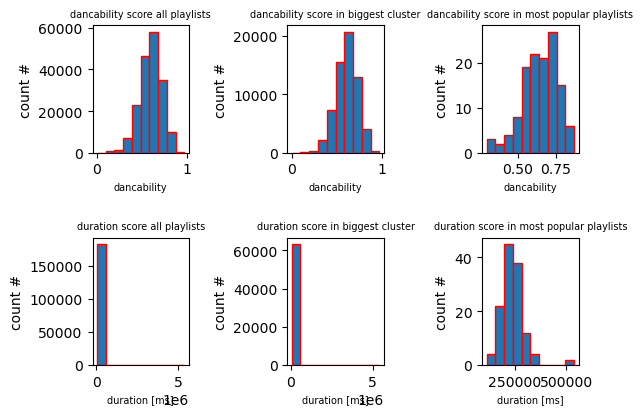

<Figure size 1000x2000 with 0 Axes>

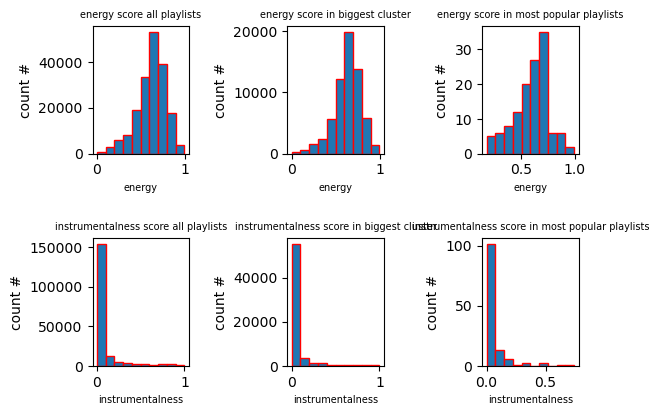

<Figure size 1000x2000 with 0 Axes>

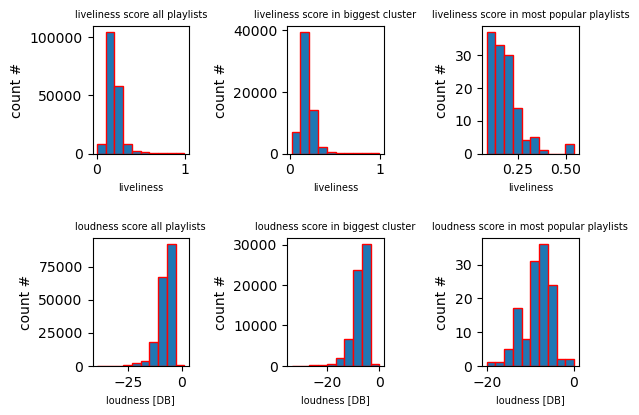

<Figure size 1000x2000 with 0 Axes>

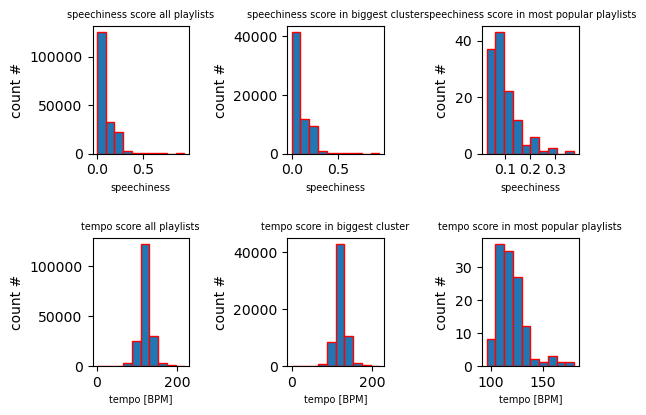

<Figure size 1000x2000 with 0 Axes>

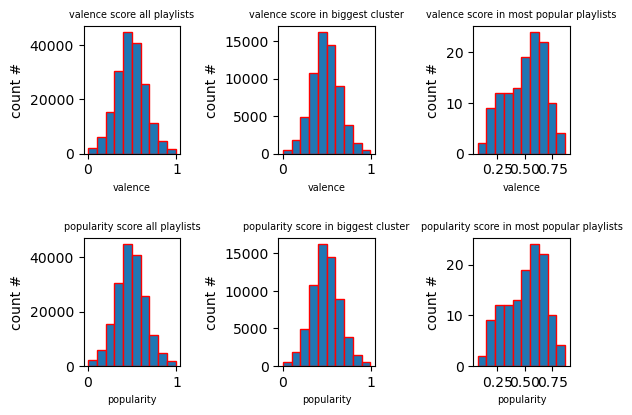

<Figure size 1000x2000 with 0 Axes>

In [ ]:
# Plots relevant histograms into subfigures
all_keys = list(complete_playlist["That's What I Like"].keys())
plotHist(2,3,all_keys[3:5])
plotHist(2,3,all_keys[5:7])
plotHist(2,3,all_keys[7:9])
plotHist(2,3,all_keys[9:11])
plotHist(2,3,all_keys[11:13])

In [ ]:
def generate_wordcloud(genre_list):
    """Generates a wordcloud based on a list of strings in the style of a Spotify logo.
    """
    # Visualizes a wordcloud of genres and how commonly they occur in all the playlists.
    unique_string=(" ").join(genre_list)
    mask = np.array(Image.open(r'Spotify_logo_without_text.png'))
    wc = WordCloud(mask = mask, background_color = "white",
                   random_state = 2, width = mask.shape[1],
                   height = mask.shape[0])
    # lower max_font_size, change the maximum number of word and lighten the background:
    wc.generate(unique_string)
    plt.imshow(wc, interpolation="None")
    plt.axis('off')
    plt.show()

In [ ]:
#Makes arrays on genres in all playlists
all_genres = []
for playlist_name in complete_playlist:
    all_genres += complete_playlist[playlist_name]['genres'] 

#Makes arrays on artists in all playlists
all_artists = []
for playlist_name in complete_playlist:
    all_artists += complete_playlist[playlist_name]['artists'] 

#Makes arrays on genres in largest cluster
popular_genres = []
for playlist_name in most_popular:
    popular_genres += complete_playlist[playlist_name]['genres'] 
    
#Makes arrays on genres in largest cluster
popular_artists = []
for playlist_name in most_popular:
    popular_artists += complete_playlist[playlist_name]['artists'] 

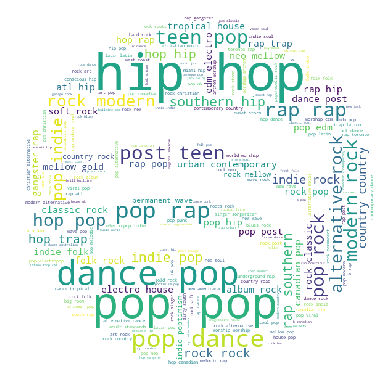

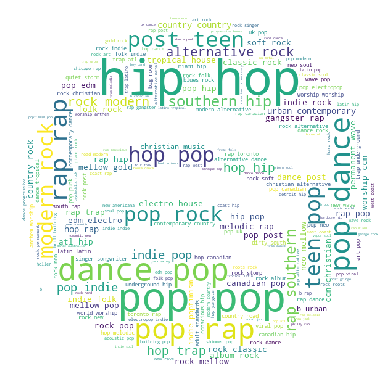

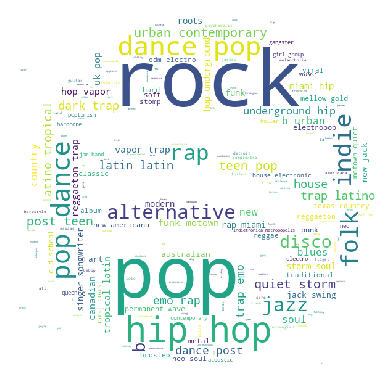

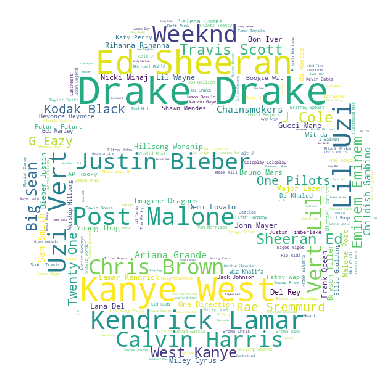

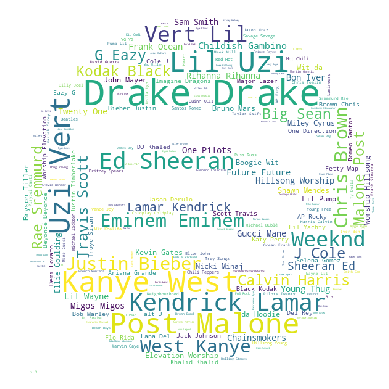

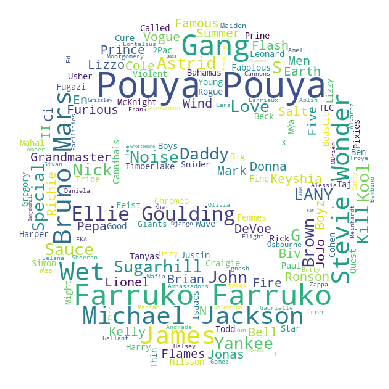

In [ ]:
# Generates the word-clouds
generate_wordcloud(all_genres)
generate_wordcloud(biggest_cluster['genres'])
generate_wordcloud(popular_genres)
generate_wordcloud(all_artists)
generate_wordcloud(biggest_cluster['artists'])
generate_wordcloud(popular_artists)